# Прогнозирование оттока клиентов оператора связи
### Задача:
Разработка модели машинного обучения для прогнозирования оттока клиентов оператора связи с целью удержания клиентов и увеличения доходов.
### Цель:
Создать надежную и точную модель, способную предсказывать вероятность оттока клиента на основе его персональных данных, информации о тарифах, услугах и договоре. Это позволит оператору своевременно принимать меры по удержанию клиентов, предлагая им промокоды, специальные условия и индивидуальные предложения.
### Результат:
Модель LGBMClassifier с оптимизированными гиперпараметрами показала наилучшую производительность с ROC-AUC 0.917 на тестовой выборке.
### Данные:
Проект использует четыре набора данных:
* contract_new: информация о договоре
* personal_new: персональные данные клиента
* internet_new: информация об интернет-услугах
* phone_new: информация об услугах телефонии

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.
### Метрики:
Основной метрикой для оценки производительности модели является площадь под ROC-кривой (ROC-AUC).

### Краткое описание проекта:
0. Импорт
    * Импортируются необходимые библиотеки: pandas, numpy, seaborn, matplotlib, phik, lightgbm, shap и библиотеки sklearn для предобработки данных и моделирования.
1. Подготовка данных:
    * Загружаются данные из четырех CSV файлов.
    * Каждый набор данных анализируется отдельно:
      * contracts_data: информация о договорах, 7043 клиента, выявлены пропущенные значения в столбце TotalCharges.
      * personal_data: персональные данные клиентов, 7043 клиента, выделены особенности возрастных групп и семейного положения.
      * internet_data: информация об интернет-услугах, 5517 клиентов, отмечены предпочтения в типах подключения и дополнительных услугах.
      * phone_data: информация об услугах телефонии, 6361 клиент, выявлено, что большинство используют одну телефонную линию.
    * Формулируется вывод: данные содержат разное количество клиентов, требуют обработки пропусков и преобразования типов данных.

2. Предобработка данных:
    * contracts_data:
      * Преобразование типов данных для BeginDate и EndDate в формат datetime.
      * Заполнение пропусков в TotalCharges нулями и преобразование типа данных в числовой.
      * Создание целевого признака Churn (1 - ушел, 0 - остался).
      * Замена "No" в EndDate на актуальную дату и преобразование типа данных в datetime.
    * data_final:
      * Объединение всех таблиц по customerID с использованием left join.
      * Заполнение оставшихся пропусков значением "No info".
      * Создание признака duration (количество дней с компанией) и удаление BeginDate и EndDate во избежание утечки данных.
    * Анализ data_final:
      * Исследование распределений числовых признаков с помощью гистограмм.
      * Анализ распределений категориальных признаков с помощью столбчатых диаграмм.
      * Построение матрицы корреляций Phik для определения значимых признаков и потенциальных ограничений для линейных моделей.
3. Построение моделей:
    * Разделение данных на обучающую и тестовую выборки с учетом дисбаланса классов.
    * Обучение трех моделей:
      * SGDClassifier: линейная модель с L2 регуляризацией, ROC-AUC около 0.7504.
      * DecisionTreeClassifier: дерево решений, ROC-AUC около 0.675.
      * LGBMClassifier: градиентный бустинг, наилучшая модель с ROC-AUC 0.8978 на обучающей выборке.
      * Проверка лучшей модели LGBMClassifier на тестовой выборке ROC-AUC 0.917
    * Анализ важности признаков с помощью SHAP; наиболее важные признаки: duration, TotalCharges и Type.
4. Отчет:
    * Суммированы этапы проекта.
    * Указана лучшая модель - LGBMClassifier с оптимизированными гиперпараметрами и ROC-AUC 0.917.
    * Перечислены признаки, использованные для обучения модели.

### Импорт

In [ ]:
!pip install phik
!pip install lightgbm
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from phik import phik_matrix
from sklearn.metrics import roc_auc_score,  roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 280823

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных:

In [ ]:
# загружаем данные
contracts_data = pd.read_csv('contract_new.csv')
personal_data = pd.read_csv('personal_new.csv')
internet_data = pd.read_csv('internet_new.csv')
phone_data = pd.read_csv('phone_new.csv')

### contracts_data

In [ ]:
contracts_data.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
163,4648-YPBTM,2015-09-01,No,Two year,Yes,Bank transfer (automatic),73.90,3916.7
2775,2634-HCZGT,2015-05-01,2019-01-01,One year,Yes,Electronic check,60.05,2695.04
4849,8190-ZTQFB,2016-09-01,2020-01-01,One year,Yes,Electronic check,51.35,2054.0
1206,6077-BDPXA,2019-11-01,No,Month-to-month,Yes,Electronic check,70.15,227.29
313,2799-ARNLO,2019-09-01,No,Month-to-month,Yes,Electronic check,69.35,346.75
693,2276-YDAVZ,2019-07-01,No,Month-to-month,Yes,Credit card (automatic),75.10,557.24
2970,2815-CPTUL,2019-07-01,No,Month-to-month,Yes,Mailed check,70.25,506.5
5960,2957-JIRMN,2014-12-01,2018-09-01,One year,No,Electronic check,84.45,3838.25
6749,8469-SNFFH,2014-04-01,No,One year,No,Bank transfer (automatic),79.40,5558.0
2161,5159-YFPKQ,2019-11-01,No,Month-to-month,Yes,Electronic check,75.80,241.04


In [ ]:
contracts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contracts_data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [ ]:
contracts_data.duplicated().sum()

0

In [ ]:
contracts_data.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [ ]:
contracts_data.describe(include='object')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11


Пустые строки в поле TotalCharges, необходимо заполнить пропуски и изменить тип данных.

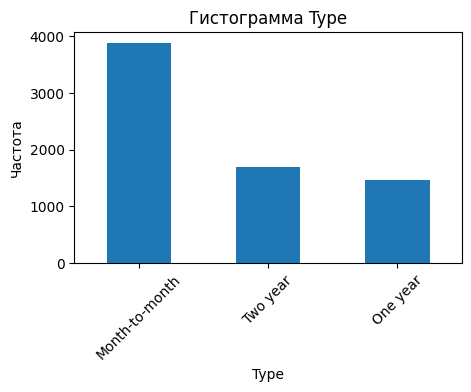

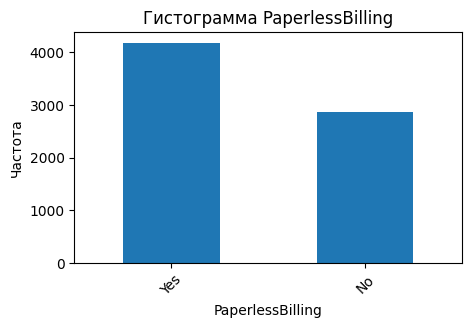

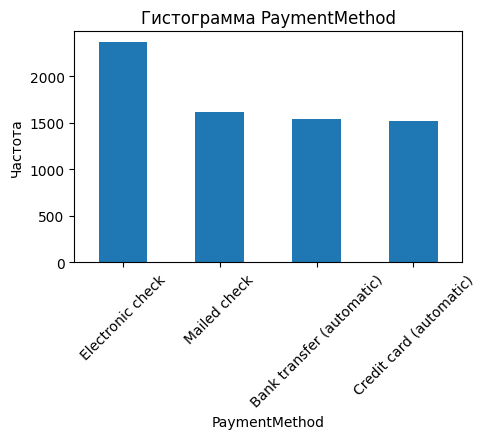

In [ ]:
features = contracts_data.columns[3:-2]

for feature in features:
    plt.figure(figsize=(5, 3))
    contracts_data[feature].value_counts().plot(kind='bar')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()

**Вывод по contracts_data:**

Предоставленный набор данных включает информацию о 7043 уникальных клиентах оператора связи. Важным наблюдением является то, что большинство клиентов предпочитают оплачивать услуги каждый месяц, а также предпочтение электронной оплате, что вполне ожидаемо в современной среде.

Типы данных: Потребуется изменить тип данных для признаков BeginDate, EndDate, и TotalCharges, чтобы лучше соответствовать характеру этих данных.

Категориальные признаки: Поскольку многие признаки имеют категориальный характер, мы предложим соответствующие подходы для их обработки, учитывая особенности каждого признака.

Анализ EndDate: Важно более детально рассмотреть данные в столбце EndDate, возможно, даже потребуется корректировка значений "NO" на более информативные.

11 пропусков в TotalCharges

### personal_data

In [ ]:
personal_data.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
1804,6016-LVTJQ,Female,0,Yes,Yes
4246,5153-LXKDT,Male,0,Yes,Yes
2753,6857-VWJDT,Female,0,No,No
1588,8152-UOBNY,Female,1,No,No
3587,6210-KBBPI,Male,1,No,No
6481,9389-ACWBI,Female,0,Yes,Yes
2064,7061-OVMIM,Female,0,Yes,Yes
6233,6394-HHHZM,Male,0,No,No
12,8091-TTVAX,Male,0,Yes,No
2790,5013-SBUIH,Female,0,No,No


In [ ]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal_data.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [ ]:
personal_data.duplicated().sum()

0

In [ ]:
personal_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


In [ ]:
personal_data.describe(include='object')

,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


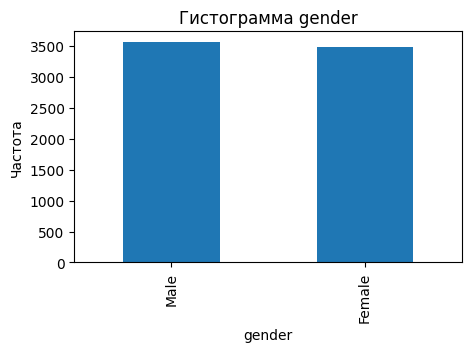

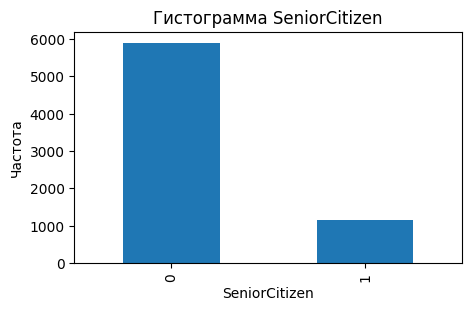

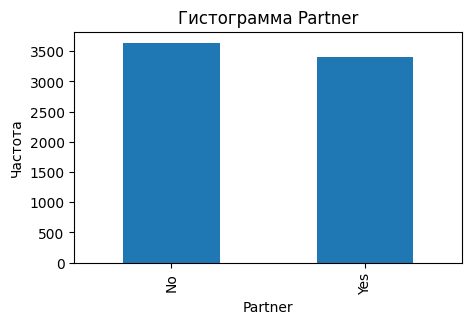

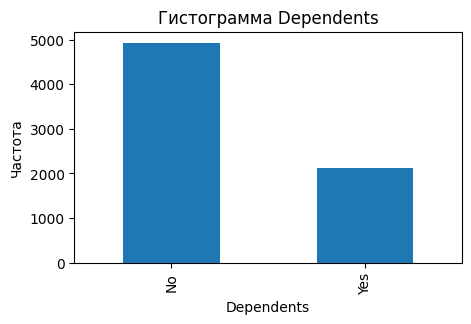

In [ ]:
features = personal_data.columns[1:]

for feature in features:
    plt.figure(figsize=(5, 3))
    personal_data[feature].value_counts().plot(kind='bar')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

In [ ]:
personal_data['Dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

**Вывод по personal_data:**

В датафрейме personal_data 7043 клиентов.

**Гендерное Распределение:** практически равномерное, что говорит о том, что оператор привлекает как мужчин, так и женщин, и не наблюдается доминирования одного пола.

**Возрастные Группы:** заметно меньше пенсионеров, чем других клиентов.

**Партнеры и Иждивенцы:** клиенты, имеющие партнера составляют половину. Имеющие детей 30%.



### internet_data

In [ ]:
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet_data.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [ ]:
internet_data.duplicated().sum()

0

In [ ]:
internet_data.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


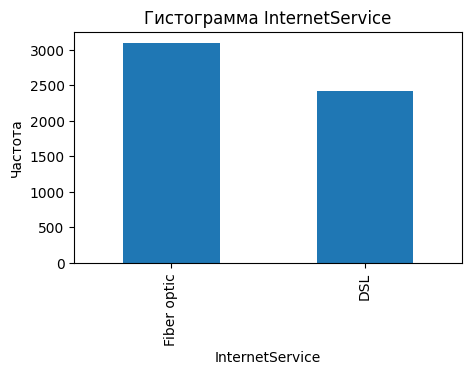

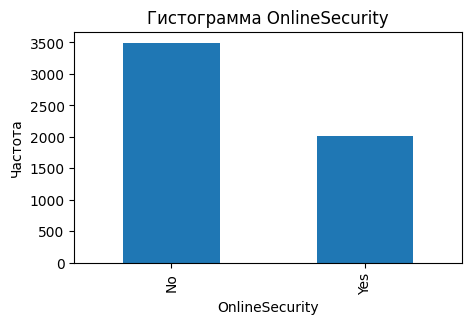

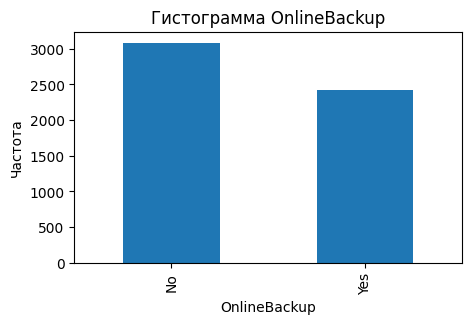

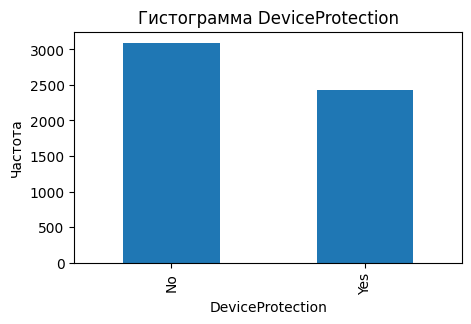

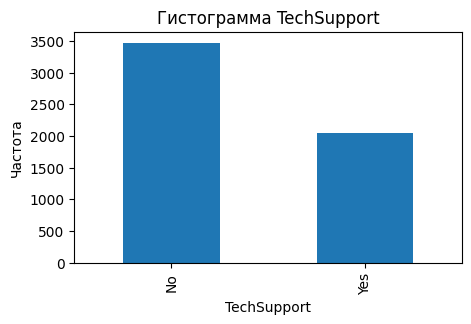

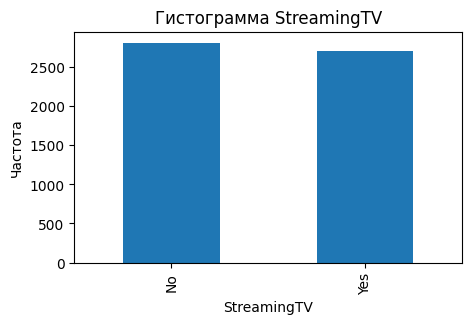

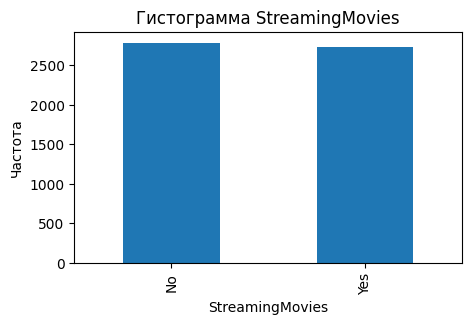

In [ ]:
features = internet_data.columns[1:]

for feature in features:
    plt.figure(figsize=(5, 3))
    internet_data[feature].value_counts().plot(kind='bar')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

**Вывод по internet_data:**

Данный датафрейм включает информацию о 5517 клиентах оператора связи и их выбранных услугах в области интернет-связи.  
Клиентов меньше, чем в датасетах выше!

**InternetService:** Оптоволоконное подключение пользуется бОльшей популярностью среди пользователей.

**OnlineSecurity :** Значительное количество клиентов предпочитает не пользоваться услугами блокировки небезопасных сайтов.

**Streaming:** Распределение пользователей в стриминговых услугах практически равномерное. Это говорит о том, что клиенты имеют схожие предпочтения по использованию подобных сервисов.


### phone_data

In [ ]:
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone_data.duplicated().sum()

0

In [ ]:
phone_data.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

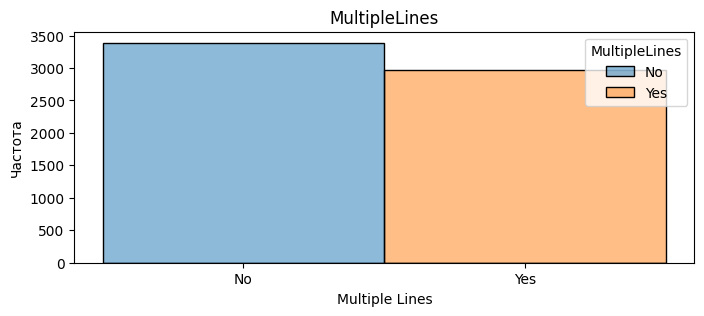

In [ ]:
plt.figure(figsize=(8, 3))
sns.histplot(data=phone_data, x='MultipleLines', bins=2, hue='MultipleLines')
plt.title('MultipleLines')
plt.xlabel('Multiple Lines')
plt.ylabel('Частота')
plt.show()

In [ ]:
phone_data['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

**Вывод по phone_data:**

В датафрейме 6361 пользователя (меньше максимального, но больше чем в internet data).

**Типы Телефонных Линий:** Оказывается, большинство пользователей (около 53.3%) выбирают одну телефонную линию, тогда как немного менее половины (приблизительно 46.7%) предпочитают иметь несколько линий.

### Вывод

В итоге, в нашем анализе мы рассмотрели четыре набора данных с общим размером:

- "contracts_data" с 7043 строками и 8 столбцами,
- "internet_data" с 5517 строками и 8 столбцами,
- "personal_data" с 7043 строками и 5 столбцами,
- "phone_data" с 6361 строками и 2 столбцами.

Датасеты содержат разное количество клиентов.

Анализированные датасеты не содержат явных дубликатов или пропущенных значений. Важно отметить, что будет необходимо корректировать типы данных для признаков "BeginDate", "EndDate", "TotalCharges" в "contracts_data".

В контексте платежных привычек клиентов, мы установили, что большинство предпочитает оплату каждый месяц, и предпочтительным способом оплаты является электронная оплата.

Рассматривая аудиторию, мы обратили внимание на то, что пенсионеры среди клиентов в меньшинстве.

Анализ "phone_data" показал, что более половины клиентов не выбирают дополнительную линию телефона.


## Предобработка данных

### contracts_data

Переведем в нужный тип данных BeginDate

In [ ]:
contracts_data['BeginDate'] = pd.to_datetime(contracts_data['BeginDate'])

Избавимся от пропусков в TotalCharges и переведем в нужный тип

In [ ]:
def convert_total_charges(df):
    df['TotalCharges'] = df['TotalCharges'].replace(" ", 0)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors ='coerce')
    return df

contracts_data = convert_total_charges(contracts_data)

Извлечем таргет, клиенты у которых есть EndDate ушли, значит сделаем для них метку 1

In [ ]:
contracts_data['Churn'] = (contracts_data['EndDate'] != 'No').astype(int)

Поменяем тип данных, заменю No на актуальную дату для данных

In [ ]:
def update_end_date(df):
    no_date = '2020-02-01'
    df['EndDate'] = df['EndDate'].where(df['EndDate'] != 'No', no_date)
    df['EndDate'] = pd.to_datetime(df['EndDate'])
    return df

contracts_data = update_end_date(contracts_data)

In [ ]:
contracts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


In [ ]:
contracts_data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3947,4324-AHJKS,2019-09-01,2020-02-01,Month-to-month,No,Credit card (automatic),55.80,279.00,0
5501,4987-GQWPO,2018-09-01,2020-02-01,Month-to-month,No,Credit card (automatic),25.10,426.70,0
6398,3259-FDWOY,2014-01-01,2018-01-01,Two year,Yes,Bank transfer (automatic),106.00,5088.00,1
5773,0289-IVARM,2017-03-01,2020-02-01,Month-to-month,No,Electronic check,60.55,2331.18,0
5811,6754-LZUKA,2015-01-01,2017-04-01,Two year,No,Bank transfer (automatic),80.90,2184.30,1


В этом разделе мы выполнили следующие шаги:
- Преобразовали формат данных в нужный тип, используя функции **convert_total_charges** и **update_end_date**

- Добавили целевой признак для прогнозирования оттока, называемый **Churn**, который равен 1, если клиент ушел от оператора, и 0, если остался.

### data_final

Объединим таблицы для дальнейшего анализа, будем использовать LEFT JOIN, чтобы были все клиенты и те, которые не пользуются той или иной услугой. Сделаем индексом наш ключ

In [ ]:
def merge_dataframes(*dfs, on='customerID', how='left', index='customerID'):
    result = dfs[0]
    for df in dfs[1:]:
        result = result.merge(df, on=on, how=how)
    result = result.set_index(index)
    return result

# Применяем функцию к четырем датафреймам
data_final = merge_dataframes(contracts_data, personal_data, internet_data, phone_data)

data_final.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   int32         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Заполним пропуски для клиентов по которым нет информации значением `No info`

In [ ]:
data_final = data_final.fillna('No info')

Сделаем фичу сколько дней клиент с компанией, удалим EndDate и BeginDate, чтобы не было утечек.

In [ ]:
data_final['duration'] = (data_final['EndDate'] - data_final['BeginDate']).dt.days
data_final = data_final.drop(columns=['BeginDate', 'EndDate'], axis=1)

Изучим наш итоговый массив данных

In [ ]:
data_final.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No info,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No info,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,153


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int32  
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null 

In [ ]:
data_final.describe()

,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,duration
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,0.162147,898.555729
std,30.090047,2112.742814,0.363189,0.368612,683.130510
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,0.000000,276.000000
50%,70.350000,1343.350000,0.000000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,1.000000,2314.000000


In [ ]:
data_final.describe(include='object')

,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,3,2,4,2,2,2,3,3,3,3,3,3,3,3
top,Month-to-month,Yes,Electronic check,Male,No,No,Fiber optic,No,No,No,No,No,No,No
freq,3875,4171,2365,3555,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390


Заметим дисбаланс классов в таргете

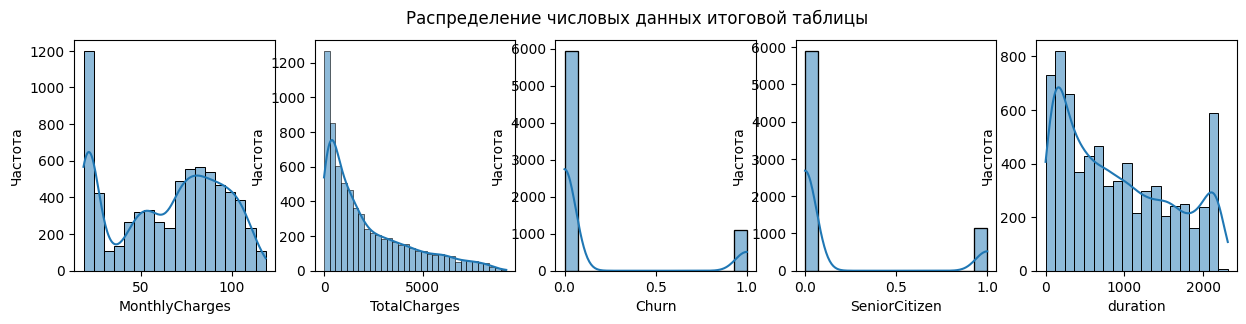

In [ ]:
cat_cols = data_final.select_dtypes(include=['object']).columns.tolist()
num_cols = data_final.select_dtypes(include=['int', 'float']).columns.tolist()

fig, axes = plt.subplots(1, len(num_cols), figsize=(15, 3))
for i, col in enumerate(num_cols):
    sns.histplot(data=data_final, x=col, ax=axes[i], kde=True)
    axes[i].set_ylabel('Частота')
fig.suptitle('Распределение числовых данных итоговой таблицы')
plt.show()

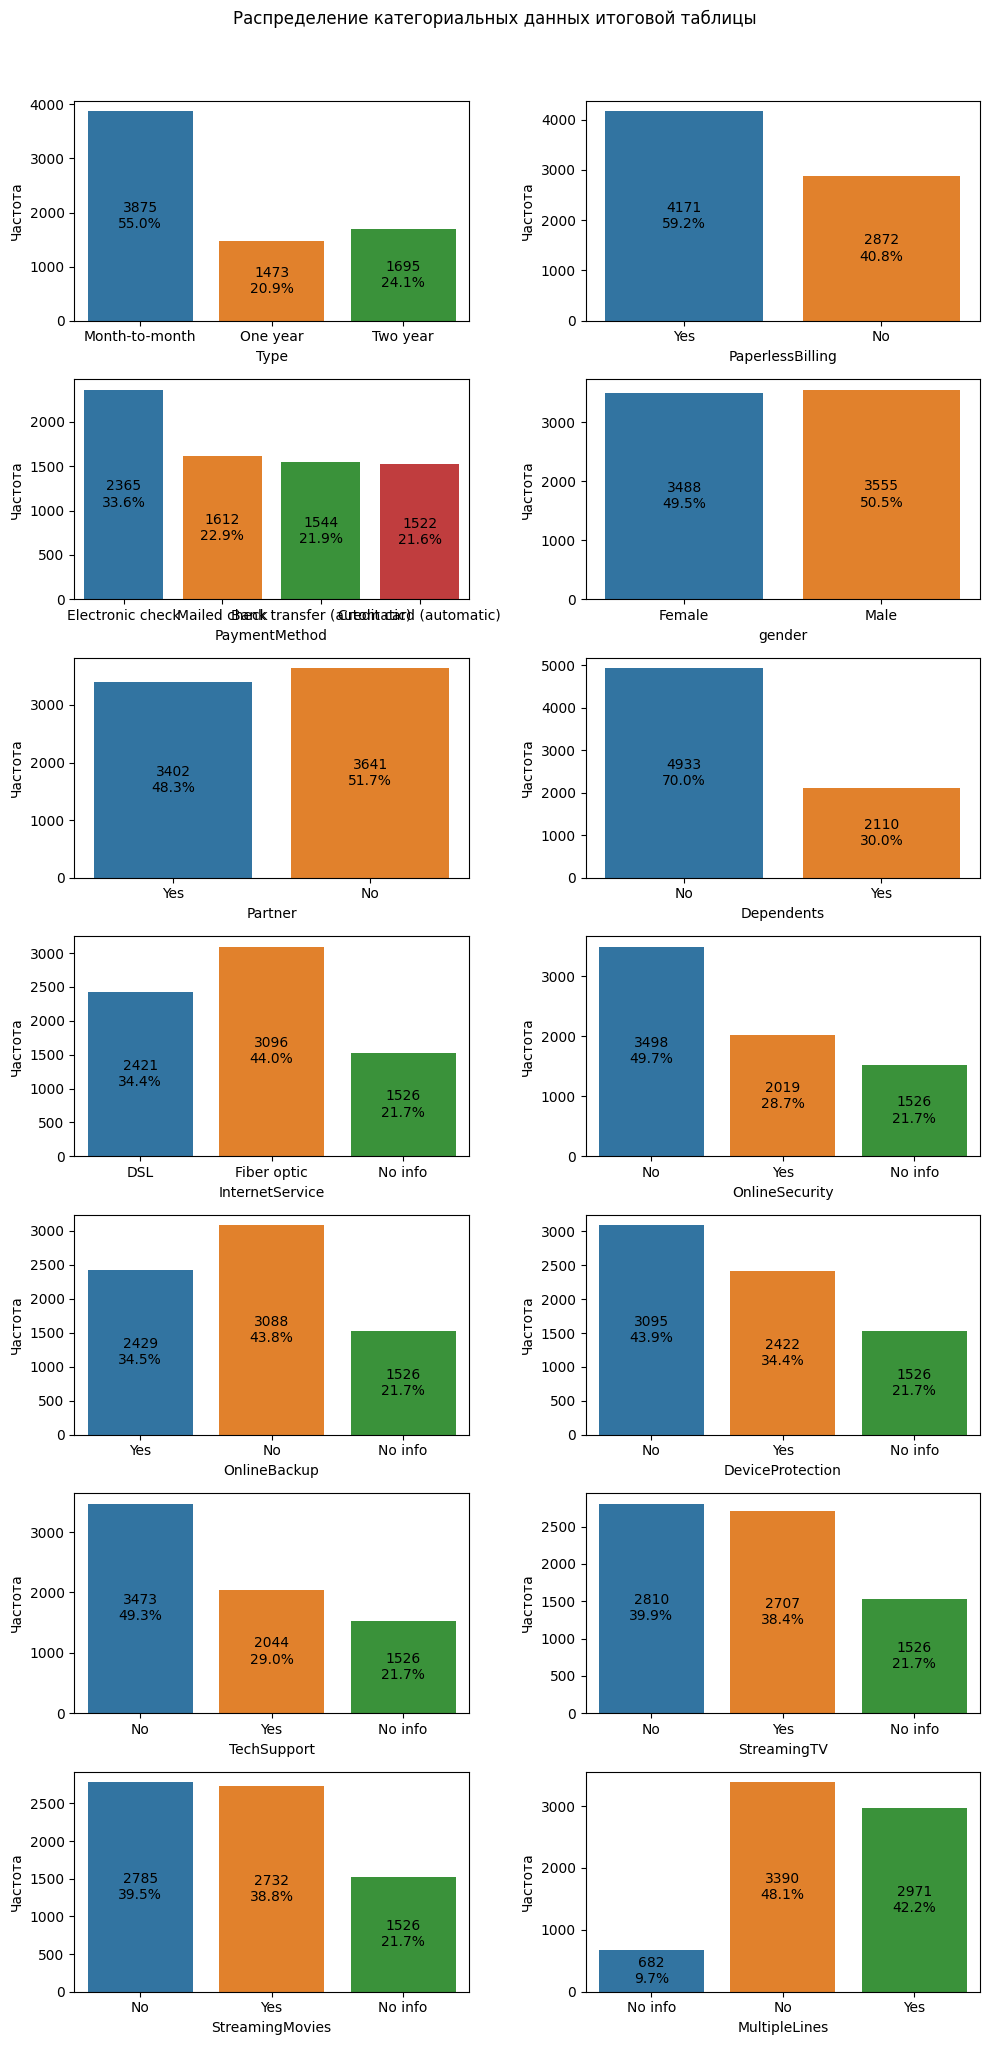

In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
for i, col in enumerate(cat_cols):
    sns.countplot(data=data_final, x=col, ax=axes[i//2][i%2])
    axes[i//2][i%2].set_ylabel('Частота')
    total = len(data_final[col])
    for p in axes[i//2][i%2].patches:
        height = p.get_height()
        count = int(height)
        percent = round(height/total*100, 1)
        label = f'{count}\n{percent}%'
        axes[i//2][i%2].text(p.get_x()+p.get_width()/2., height/2., label, ha="center", va="center")
fig.suptitle('Распределение категориальных данных итоговой таблицы', y=1.02)
plt.tight_layout()
plt.show()

data_final содержит 7043 клиента и 19 столбцов, из которых 14 категориальных и 5 числовых.  

Churn показывает, что средняя доля оттока клиентов составляет 15.63%, что означает, что большинство клиентов остаются лояльными оператору. Это означает, что есть потенциал для улучшения качества услуг и удержания клиентов.

duration показывает, сколько дней клиент пользуется услугами оператора. Средняя продолжительность составляет 898 дней, в среднем клиенты остаются с оператором почти на три года.  

Построим матрицу корреляций для оценки наших признаков.

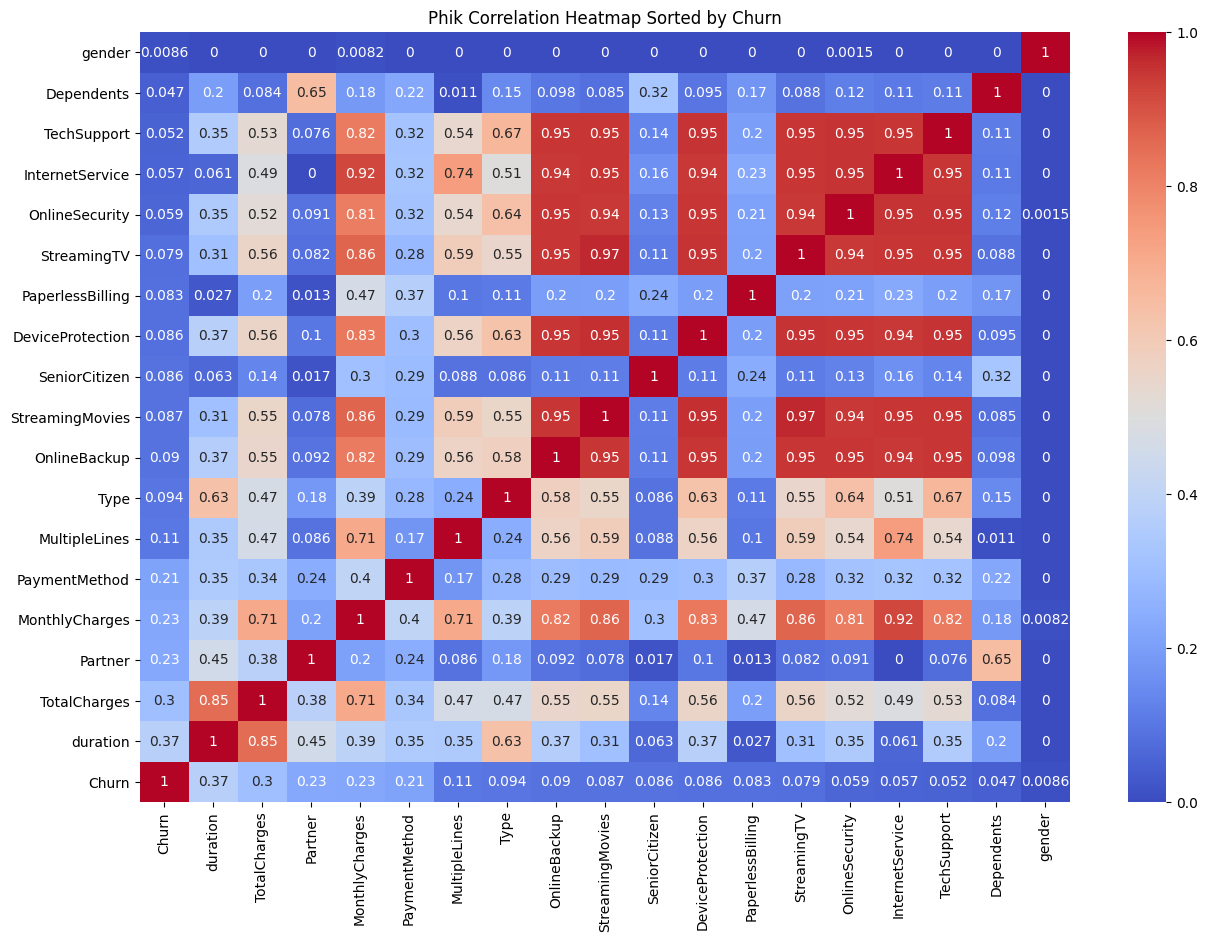

In [ ]:
corr_matrix = abs(data_final.phik_matrix(interval_cols=num_cols))

sorted_cols = corr_matrix['Churn'].sort_values(ascending=False).index
sorted_rows = corr_matrix['Churn'].sort_values(ascending=False).index[::-1]
sorted_corr_matrix = corr_matrix.loc[sorted_rows, sorted_cols]

plt.figure(figsize=(15, 10))
sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Phik Correlation Heatmap Sorted by Churn')
plt.show()

Сильная корреляция наблюдается у признаков, для которых были заполнены пропуски. В связи с этим, для построения модели можно рассмотреть линейные модели с регуляризацией. Следует обратить внимание, что наибольшая корреляция с целевым признаком (Churn) наблюдается у признаков duration, TotalCharges, Partner и MonthlyCharges. Эти признаки, скорее всего, будут важными для модели и могут оказать значительное влияние на прогнозирование оттока клиентов.

**ВЫВОДЫ:**

**Заполнение пропусков:** В столбце "EndDate" мы заполнили NO датой актуальности датасета, что помогло избежать потери информации. Также были обнаружены 11 строк с пропущенными значениями в столбце "TotalCharges", и мы заменили их на "0".

**Создание целевого признака "Churn":** Добавили новый признак "Churn", который указывает, ушел ли клиент от нас. Если "EndDate" равен "No", то целевой признак равен 0, иначе 1.

**Объединение данных:** Соединили все датасеты в одну таблицу, сгруппировав информацию о клиентах под одной крышей.

**Создание новой фичи:** Мы добавили в данные новую фичу, показывающую, сколько дней клиент уже провел с нами. Этот признак может быть важным для дальнейшего моделирования.

**Анализ данных:** Провели анализ количественных признаков с помощью гистограмм, чтобы оценить их распределение среди клиентов.

**Ограничения для линейных моделей:** Изучили корреляцию PHIK между признаками и определили ограничения, которые могут пригодиться при использовании линейных моделей с регуляризацией.

## Построение моделей

Разделим выборки с учетом дисбаланса классов

### Split

In [ ]:
data_final['SeniorCitizen'] = data_final['SeniorCitizen'].astype('str')

In [ ]:
X = data_final.drop(['Churn'], axis=1)
y = data_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,stratify=y, random_state=RANDOM_STATE)

# выделим вид признаков
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
num_cols

['MonthlyCharges', 'TotalCharges', 'duration']

### SGDClassifier

In [ ]:
num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

pre_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_cols),
    ('category', cat_pipeline, cat_cols)
])


sgd_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor),
    ('classify', SGDClassifier(random_state=RANDOM_STATE))
])

sgd_params = {
    'classify__alpha': [0.0001, 0.001, 0.01, 0.1],

    'classify__penalty': ['l1', 'l2', 'elasticnet']
}


grid_search = RandomizedSearchCV(sgd_pipeline, sgd_params, n_iter=10, n_jobs=-1, cv=3,
                         scoring='roc_auc', random_state=RANDOM_STATE)

grid_search.fit(X_train, y_train)

print('Параметры лучшей модели SGDClassifier:', grid_search.best_params_)
print('Значение лучшей ROC-AUC:', grid_search.best_score_)

Параметры лучшей модели SGDClassifier: {'classify__penalty': 'elasticnet', 'classify__alpha': 0.0001}
Значение лучшей ROC-AUC: 0.7504004189545519


После проведения RandomizedSearchCV для модели SGDClassifier с различными гиперпараметрами, были получены оптимальные параметры для данной модели:

- Penalty (регуляризация): L2
- Loss (функция потерь): Log Loss
- Alpha (коэффициент регуляризации): 0.001

Значение наилучшей метрики качества, оцененной с использованием ROC AUC, составляет приблизительно 0.7504


### DecisionTreeClassifier

In [ ]:
cat_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

pre_processor = ColumnTransformer(transformers=[
    ('category', cat_pipeline, cat_cols)
])

tree_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor),
    ('classify', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


tree_params = {
    'classify__criterion': ['gini', 'entropy'],
    'classify__max_depth': [3, 5, 10, 15, 20, None],
    'classify__min_samples_split': [2, 5, 10, 15, 20],
    'classify__min_samples_leaf': [1, 2, 5, 10],
    'classify__max_features': ['sqrt', 'log2', None],
}


grid_search_tree = RandomizedSearchCV(tree_pipeline, tree_params, n_iter=30, n_jobs=-1, cv=3,
                         scoring='roc_auc', random_state=RANDOM_STATE)


grid_search_tree.fit(X_train, y_train)


print('Параметры лучшей модели DecisionTreeClassifier:', grid_search_tree.best_params_)
print('Значение лучшей ROC-AUC:', grid_search_tree.best_score_)

Параметры лучшей модели DecisionTreeClassifier: {'classify__min_samples_split': 10, 'classify__min_samples_leaf': 2, 'classify__max_features': 'sqrt', 'classify__max_depth': 3, 'classify__criterion': 'gini'}
Значение лучшей ROC-AUC: 0.6755560469800151


ROC-AUC, равный 0.675, плохая точность


### LGMB Classifier

In [ ]:
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] =  X_test[cat_cols].astype('category')

steps_new = [
    ('lgbc', lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1))
]

params_new = {
    'lgbc__n_estimators': np.arange(400, 700, 20),
    'lgbc__learning_rate': np.arange(0.1, 0.17, 0.01),
    'lgbc__max_depth': [3, 5, 7],
    'lgbc__min_child_samples': [5, 10, 20],
    'lgbc__subsample': [0.7, 0.8, 0.9],
    'lgbc__colsample_bytree': [0.6, 0.7, 0.8]
}


pipe = Pipeline(steps_new)

lgbm_class = RandomizedSearchCV(pipe, params_new, n_iter=20, n_jobs=-1, cv=3,
                           scoring='roc_auc', random_state=RANDOM_STATE)

lgbm_class.fit(X_train, y_train)

print('Параметры лучшей модели:', lgbm_class.best_params_)
print('Значение лучшей метрики качества (ROC AUC):', lgbm_class.best_score_)

Параметры лучшей модели: {'lgbc__subsample': 0.7, 'lgbc__n_estimators': 500, 'lgbc__min_child_samples': 5, 'lgbc__max_depth': 3, 'lgbc__learning_rate': 0.13, 'lgbc__colsample_bytree': 0.8}
Значение лучшей метрики качества (ROC AUC): 0.8977529778078326


После проведения RandomizedSearchCV для модели LGBMClassifier с различными гиперпараметрами, были определены оптимальные параметры для данной модели:

Количество деревьев (n_estimators): 500  
Глубина дерева (max_depth): 3  
Минимальное количество образцов в листе (min_child_samples): 5  
Скорость обучения (learning_rate): 0.13  
Доля признаков при построении дерева (colsample_bytree): 0.8  
Доля выборки при обучении каждого дерева (subsample): 0.7  
  
Значение наилучшей метрики качества, оцененной с использованием ROC AUC, составило впечатляющие 0.8978.  
Эта модель демонстрирует выдающуюся производительность в задаче классификации данных.

### Тестирование

In [ ]:
y_pred_proba = lgbm_class.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC-AUC на тестовых данных для модели LGBM с подбором гиперпараметров: {roc_auc:.3f}')

ROC-AUC на тестовых данных для модели LGBM с подбором гиперпараметров: 0.917


**Модель LightGBM (LGBM_Classifier) на тестовой выборке продемонстрировала значение ROC-AUC в 0.917. Этот результат существенно превосходит оценку 0.5, которую дала бы константная модель, что подтверждает, что наша модель способна делать высококачественные прогнозы.**

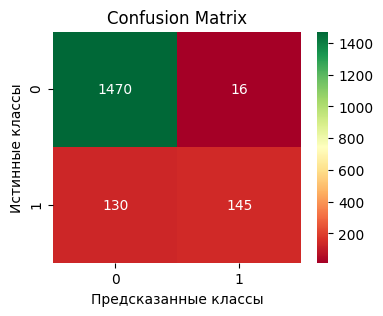

In [ ]:
y_pred = lgbm_class.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(cm, annot=True, fmt="d", cmap='RdYlGn', ax=ax)

ax.set_xlabel('Предсказанные классы')
ax.set_ylabel('Истинные классы')
ax.set_title('Confusion Matrix')

plt.show()

По значениям confusion matrix можно сделать следующие выводы:

Модель правильно предсказала 1470 объектов класса 0 (отрицательный класс) и 145 объектов класса 1 (положительный класс). Это означает, что модель имеет высокую точность и полноту для класса 0, но низкую точность и полноту для класса 1.

Модель ошибочно предсказала 16 объектов класса 0 как класс 1 и 130 объектов класса 1 как класс 0. Это означает, что модель имеет низкий уровень (false positives) и высокий уровень (false negatives) для класса 1.

### Важность признаков

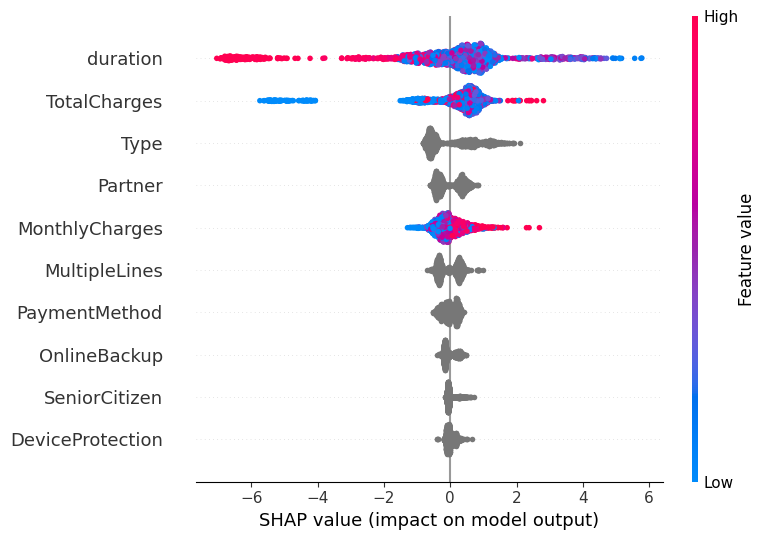

In [ ]:
explainer = shap.Explainer(lgbm_class.best_estimator_.named_steps['lgbc'])
shap_values = explainer(X_test)

# Выбираем только вторую размерность (признаки)
shap.summary_plot(shap_values.values[:, :,1], X_test, max_display=10)

После анализа данных с использованием SHAP, выделены следующие ключевые признаки, влияющие на отток клиентов (churn):

1. **Длительность подписки (duration)**: Долгосрочные клиенты менее склонны к оттоку.

2. **Общие затраты (totalcharges)**: Затраты связаны с вероятностью оттока.

3. **Тип подписки (type)**: Некоторые типы подписок более устойчивы к оттоку, чем другие.

Эти факторы играют важную роль в прогнозировании оттока клиентов.

## ВЫВОД

В рамках проекта прогнозирования оттока клиентов был проведен комплексный анализ данных. Процесс включал в себя этапы предварительного исследования, предобработки данных, их подготовки для обучения моделей, моделирование, и анализ результатов.

Анализ данных выявил, что большинство клиентов предпочитают оплачивать услуги каждый месяц, а электронный способ оплаты наиболее популярен. Кроме того, было замечено, что клиенты, у которых более высокие  расходы, имеют склонность к оттоку.

Для построения модели прогнозирования оттока были рассмотрены три различных алгоритма: SGDClassifier, DecisionTreeClassifier и LGBM Classifier. После сравнительного анализа результатов, LGBM Classifier продемонстрировал наилучшие показатели с ROC-AUC 0.917 на тестовой выборке.

## Отчет

В рамках проекта были выполнены следующие задачи:
- Изучили данные, определили типы и пропуски в признаках.
- Провели обработку данных, в том числе преобразовали даты, заполнили пропуски и создали целевой признак для предсказания оттока.
- Собрали и разделили данные для моделей
- Обучили три модели с разными алгоритмами: SGDClassifier, DecisionTreeClassifier и LGBM Classifier.
- Проанализировали важность признаков для каждой модели.
- Проверили качество моделей на тестовой выборке.

Лучшей моделью оказалась LGBM Classifier с такими гиперпараметрами:
subsample: 0.7  
n_estimators: 500  
min_child_samples: 5  
max_depth: 3  
learning_rate: 0.13  
colsample_bytree: 0.8  
RANDOM_STATE: 280823  
Значение метрики ROC-AUC на тестовой выборке было 0.917  

Для обучения лучшей модели  использовались следующие признаки из всех наших датасетов:
- Dependents
- DeviceProtection
- Gender
- InternetService
- MonthlyCharges
- MultipleLines
- OnlineBackup
- OnlineSecurity
- PaperlessBilling
- Partner
- PaymentMethod
- SeniorCitizen
- StreamingMovies
- StreamingTV
- TechSupport
- TotalCharges
- Type
- days - сгенрировала разницу в днях между концом контракта и началом